In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Модель возмущения ионосферы

## Полезные формулы
Круговая плазменная частота:
$$
\omega_{\text{pe}}\Big[\frac{\text{rad}}{\text{s}}\Big]=\sqrt{\frac{4\pi N_\text{e} e^2}{m_\text{e}}}
$$
Плазменная частота:
$$
\quad f_{\text{pe}}\Big[\text{Hz}\Big]=\frac{\omega_{\text{pe}}}{2\pi}
$$


Связь плазменной частоты \\(f_{\text{pe}}\\) и электронной концентрации \\(N_\text{e}\\) (расчетные формулы):
$$f_{\text{pe}}[\text{Hz}] = 0.897818235285877\times10^4\times \sqrt{N_{\text{e}}[\text{cm}^{-3}]}$$

$$N_\text{e}[\text{cm}^{-3}]  = 1.24057537429491\times10^{-8} \times f^2_{\text{pe}}[\text{Hz}]$$

In [37]:
def Ne_to_fpe(Ne):
    # convert electron concentration to electron plasma frequency
#     return 8978.18235285877*np.sqrt(Ne)
    return 8978.18235285877*np.sqrt(np.abs(Ne)) # модуль нужен, чтобы небыло предупреждений при построении графиков из-за взятия корня от -0.
def fpe_to_Ne(fpe):
    # convert electron plasma frequency to electron concentration
    return 1.24057537429491*fpe**2*1e-8

## Модель стационарного параболического слоя

В качестве базовой модели будем использовать одномерное распределение концентрации электронов $N$ по высоте в виде параболы.
Зафиксируем 3 точки параболы:
1. Точка с максимальной концентрацией $N_\text{max}$.
Так как электронная концентрация связана плазменной частотой, то величина $N_\text{max}$ определяет критическую частоту ионосферы $f_\text{max}$. Зададим $f_\text{max} = 5$ МГц на высоте $z_\text{max}=250$ км. При этом величина $N_\text{max}$ будет равна: $310143.8435737275 \: \text{cm}^{-3}$

In [4]:
# проверка
fmax = 5000000
Nmax = fpe_to_Ne(fmax)
print(Nmax)

310143.8435737275


2. Нижняя граница ионосферы. Примем для определенности, что параболический слой начинается с высоты $z_1=150$ км. Таким образом этой высоте будет соответствовать нулевая концентрация электронов.
3. Верхняя граница ионосферы. Аналогичным образом определимся, что плазменный слой полностью иссякает на высоте $z_2=350$ км.

Исходя из этих условий, определим уравнение параболы:
$$N_0(z) = a(z-z_1)(z-z_2)$$
$$N_0(z_\text{max}) = a(z_\text{max}-z_1)(z_\text{max}-z_2)=N_\text{max}$$
$$a = \frac {N_\text{max}} {(z_\text{max}-z_1)(z_\text{max}-z_2)} $$

$$ N_0(z) = N_\text{max} \frac{(z-z_1)(z-z_2)}{(z_\text{max}-z_1)(z_\text{max}-z_2)}$$

Добавив в последнюю формулу комбинацию функций Хевисайда ($h$), запретим параболе принимать отрицательные значения.
В итоге получим расчетную формулу:
$$
N_0(z[\text{m}]) [\text{cm}^{-3}]= N_\text{max}[\text{cm}^{-3}] \frac{(z[\text{m}]-z_1[\text{m}])(z[\text{m}]-z_2[\text{m}])}{(z_\text{max}[\text{m}]-z_1[\text{m}])(z_\text{max}[\text{m}]-z_2[\text{m}])}
\bigg(
h(z[\text{m}]-z_1[\text{m}])-h(z[\text{m}]-z_2[\text{m}])
\bigg)
$$

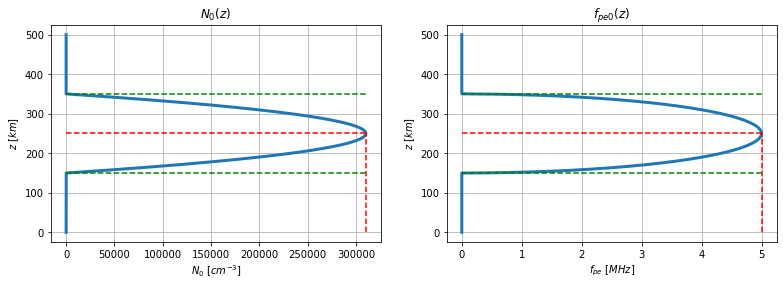

In [5]:
z1, z2, zmax = 150000, 350000, 250000

z_axe=np.linspace(0,500000,500001)
N0_axe = Nmax*(z_axe-z1)*(z_axe-z2)/(zmax-z1)/(zmax-z2)*(np.heaviside(z_axe-z1,0)-np.heaviside(z_axe-z2,0))

fig = plt.figure(figsize=(13,4))
ax = plt.subplot(1,2,1)

plt.plot(N0_axe,z_axe/1000, lw=3)

plt.plot([Nmax,Nmax],[0,zmax/1000],'r--')
plt.plot([0,Nmax],[zmax/1000,zmax/1000],'r--')
plt.plot([0,Nmax],[z1/1000,z1/1000],'g--')
plt.plot([0,Nmax],[z2/1000,z2/1000],'g--')

plt.title('$N_0(z)$')
plt.xlabel('$N_0\ [{cm}^{-3}]$')
plt.ylabel('$z\ [km]$')

plt.grid()
ax = plt.subplot(1,2,2)
plt.plot(Ne_to_fpe(N0_axe)/1e6,z_axe/1000, lw=3)
plt.plot([fmax/1e6,fmax/1e6],[0,zmax/1000],'r--')
plt.plot([0,fmax/1e6],[zmax/1000,zmax/1000],'r--')
plt.plot([0,fmax/1e6],[z1/1000,z1/1000],'g--')
plt.plot([0,fmax/1e6],[z2/1000,z2/1000],'g--')

plt.grid()
plt.title('$f_{pe0}(z)$')
plt.xlabel('$f_{pe}\ [MHz]$')
plt.ylabel('$z\ [km]$')
plt.show()

## Модель возмущения параболического слоя

Будем использовать гауссово распределение в качестве модели возмущения параболического слоя. Предположим, что возмущение ионосферного слоя обусловлено накачкой на частоте $f_P=4.6$ МГц. Определим высоту отражения волны накачки от невозмущенного профиля:
1. Частоте 4.6 МГц соответствует электронная концентрация 262505.74920080294 $\text{cm}^{-3}$

In [6]:
# проверка
f_pump = 4600000
N_pump = fpe_to_Ne(4600000)
print(N_pump)

262505.74920080294


2. По графику зависимости $N_0(z)$ можно определить высоту отражения - $z_0=210808$ м.

In [7]:
# проверка
z0 = z_axe[np.abs(N0_axe - N_pump).argmin()]
print(z0)

210808.0


Возьмем в качестве центра возмущения высоту отражения $z_0$ от плазменного слоя волны накачки с частотой $f_P$. Максимальную амплитуду возмущения концентрации ($\Delta_{N}$) возьмем равной 10% от величины электронной концентрации невозмущенного плазменного слоя на высоте отражения волны накачки:
$$\Delta_{N} = 0.1\cdot262505.74920080294= 26250.574920080297 \:\text{cm}^{-3}$$

In [8]:
# проверка
dN = 0.1*N_pump
print(dN)

26250.574920080297


Среднее квадратичное отклонение распределения максимального возмущения ($\delta_z$) возьмем равным 3000 м.

In [9]:
d_z = 3000

В итоге получим функцию распределения максимального возмущения $\Delta n (z)$:
$$
\Delta n (z) = - \Delta_{N} \exp\bigg\{-\frac{(z-z_0)^2}{2\delta_z^2} \bigg\}
$$

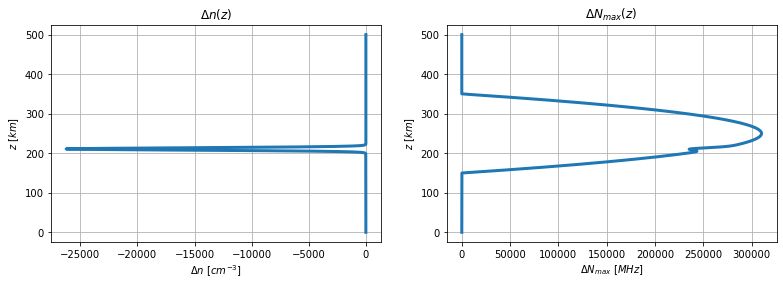

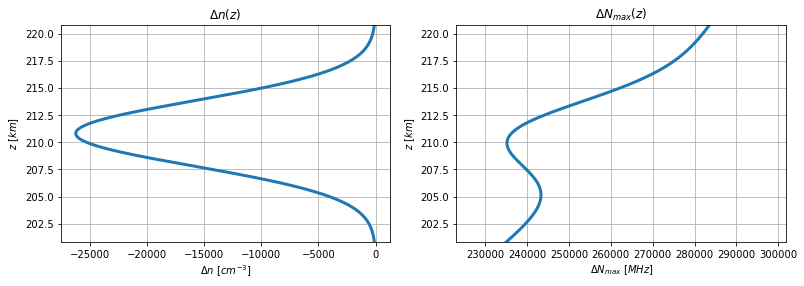

In [10]:
dN_max_axe = -dN*np.exp(-(z_axe-z0)**2/2/d_z**2)

fig = plt.figure(figsize=(13,4))
ax = plt.subplot(1,2,1)
plt.plot(dN_max_axe,z_axe/1000, lw=3)
plt.title('$\Delta n(z)$')
plt.xlabel('$\Delta n\ [{cm}^{-3}]$')
plt.ylabel('$z\ [km]$')
plt.grid()
ax = plt.subplot(1,2,2)
plt.plot(N0_axe+dN_max_axe,z_axe/1000, lw=3)
plt.grid()
plt.title('$\Delta N_{max}(z)$')
plt.xlabel('$\Delta N_{max}\ [MHz]$')
plt.ylabel('$z\ [km]$')
plt.show()

fig = plt.figure(figsize=(13,4))
ax = plt.subplot(1,2,1)
plt.plot(dN_max_axe,z_axe/1000, lw=3)
plt.ylim(z0/1000-10,z0/1000+10)
plt.title('$\Delta n(z)$')
plt.xlabel('$\Delta n\ [{cm}^{-3}]$')
plt.ylabel('$z\ [km]$')
plt.grid()
ax = plt.subplot(1,2,2)
plt.plot(N0_axe+dN_max_axe,z_axe/1000, lw=3)
plt.ylim(z0/1000-10,z0/1000+10)
plt.xlim(0.85*N_pump,1.15*N_pump)
plt.grid()
plt.title('$\Delta N_{max}(z)$')
plt.xlabel('$\Delta N_{max}\ [MHz]$')
plt.ylabel('$z\ [km]$')
plt.show()

Обеспечим нестационарность модели: плавное нарастание и релаксацию возмущения с характерными временами ($\tau_r$ и $\tau_d$) соответственно, а также задержку времени начала фаз нарастания и релаксации ($t_r$ и $t_s$ соответственно). Для этого введем функцию $f(t)$:
$$
f(t) = \bigg(1-\exp\big\{-(t-t_r)/\tau_r\big\}\bigg) \bigg(h(t-t_r)-h(t-t_d)\bigg)+
\bigg(1-\exp\big\{ -(t_d-t_r)/\tau_r \big\}\bigg)\cdot \exp\bigg\{ -(t-t_d)/\tau_d \bigg\} h(t-t_d)
$$

In [19]:
def func_f(t,t_r,t_d,tau_r,tau_d):
    # calculate f(t)
    return (1-np.exp(-(t-t_r)/tau_r))*(np.heaviside(t-t_r,0)-(np.heaviside(t-t_d,0)))+\
(1-np.exp(-(t_d-t_r)/tau_r))*np.exp(-(t-t_d)/tau_d)*np.heaviside(t-t_d,0)

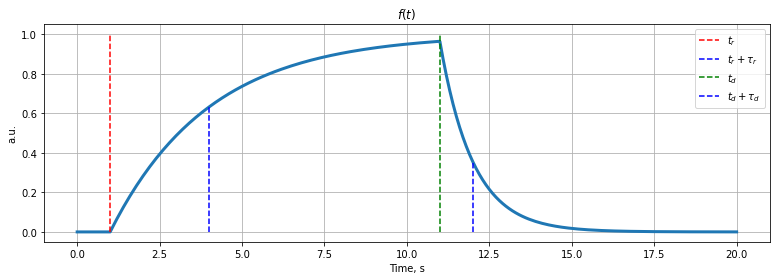

In [20]:
t_r=1
t_d=10+1
tau_r=3
tau_d=1

t_axe = np.linspace(0,20,201)
f_axe = func_f(t_axe,t_r,t_d,tau_r,tau_d)


fig = plt.figure(figsize=(13,4))
plt.plot(t_axe,f_axe,lw=3)
plt.plot([t_r,t_r],[0,1],'r--',label='$t_r$')
plt.plot([t_r+tau_r,t_r+tau_r],[0,0.64],'b--',label=r'$t_r+\tau_r$')
plt.plot([t_d,t_d],[0,1],'g--',label='$t_d$')
plt.plot([t_d+tau_d,t_d+tau_d],[0,0.35],'b--',label=r'$t_d+\tau_d$')
plt.title('$f(t)$')
plt.xlabel('Time, s')
plt.ylabel('a.u.')
plt.legend()
plt.grid()
plt.show()

Собрав все вместе получим итоговую функцию, характеризующую модельную зависимость электронной концентрации от высоты и времени:
$$
N(z,t) = N_0(z) + \Delta n(z) f(t)
$$

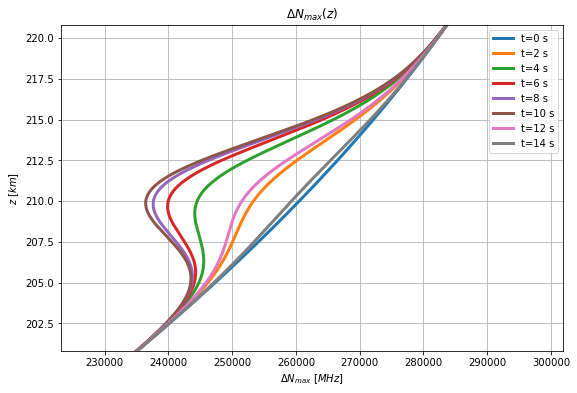

In [29]:
fig = plt.figure(figsize=(9,6))
ax = plt.subplot(1,1,1)

for t in np.arange(0,15,2):
    f = func_f(t, t_r, t_d, tau_r, tau_d)
    plt.plot(N0_axe+dN_max_axe*f,z_axe/1000, lw=3, label='t='+str(t)+' s')

plt.ylim(z0/1000-10,z0/1000+10)
plt.xlim(0.85*N_pump,1.15*N_pump)
plt.grid()
plt.legend()
plt.title('$\Delta N_{max}(z)$')
plt.xlabel('$\Delta N_{max}\ [MHz]$')
plt.ylabel('$z\ [km]$')
plt.show()

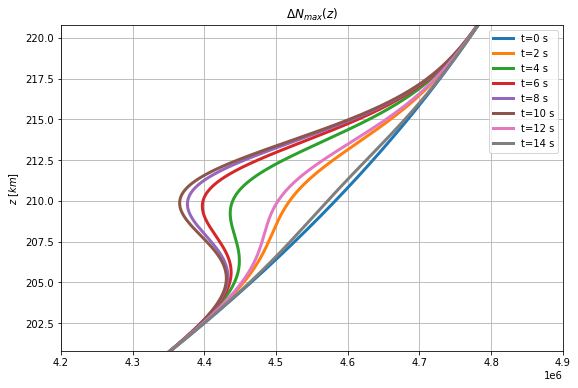

In [38]:
fig = plt.figure(figsize=(9,6))
ax = plt.subplot(1,1,1)

for t in np.arange(0,15,2):
    f = func_f(t, t_r, t_d, tau_r, tau_d)
    plt.plot(Ne_to_fpe(N0_axe+dN_max_axe*f),z_axe/1000, lw=3, label='t='+str(t)+' s')

plt.ylim(z0/1000-10,z0/1000+10)
plt.xlim(42e5,49e5)
plt.grid()
plt.legend()
plt.title('$\Delta N_{max}(z)$')
# plt.xlabel('$\Delta N_{max}\ [MHz]$')
plt.ylabel('$z\ [km]$')
plt.show()